# Analysis of Meditation Practise

In [136]:
import pandas as pd
import numpy as np
from os import path

The file with the values are read:

In [137]:
fname = "C://Users/dirkm/Meditationszeiten_ab_Okt_2017.csv"
f1name = path.expanduser(fname)
df = pd.read_csv(f1name)
df.head()

,datum,tag,dauer,wochentag
0,21/10/2017,1,52,Samstag
1,22/10/2017,2,60,Sonntag
2,23/10/2017,-,0,Montag
3,24/10/2017,-,0,Dienstag
4,25/10/2017,3,43,Mittwoch


Only the column called 'dauer' is used, because all others will be derived in a much faster and less error-prone way. 
We start with extracting the daily meditation time from column 'dauer':

In [138]:
duration = df['dauer']
duration.head()

0    52
1    60
2     0
3     0
4    43
Name: dauer, dtype: int64

Now the column in df called 'datum' is recreated by using the efficient datetime64 object within pandas:

In [139]:
date = np.array('2017-10-21', dtype=np.datetime64)
date = date + np.arange(189)

In order to count the meditation days starting with day 1, instead of day 0, a new column called 'count' is created:

In [140]:
count = np.array(range(1,190))

Let's check that the amount of rows is equal, before we combine them to one table:

In [141]:
len(df), len(date), len(count)

(189, 189, 189)

Now it's time to assemble the final table, defined as a DataFrame in pandas:

In [142]:
date_df = pd.DataFrame({'date': date, 'count': count, 'duration': duration})
date_df.head()

,count,date,duration
0,1,2017-10-21,52
1,2,2017-10-22,60
2,3,2017-10-23,0
3,4,2017-10-24,0
4,5,2017-10-25,43


Let's check the data structure residing in any single row:

In [143]:
one_row = date_df.iloc[0]
print(one_row)
print(type(one_row['count']))
print(type(one_row['date']))
print(type(one_row['duration']))

count                         1
date        2017-10-21 00:00:00
duration                     52
Name: 0, dtype: object
<class 'numpy.int32'>
<class 'pandas._libs.tslib.Timestamp'>
<class 'numpy.int64'>


In the next step we want to deduct the weekday from the datetime64 object. Let's try if the first day produces a Saturday, as in the original table:

In [144]:
date_df.iloc[0]['date'].strftime('%A')

'Saturday'

Now we extend this to all rows, by first creating an empty list of weekdays, then iterating over each of the rows to calculate the weekday and append it to list:

In [145]:
weekdays = []
for i in range(0, len(date_df)):
    weekdays.append(date_df.iloc[i]['date'].strftime('%A'))

The final table shall now be assembled:

In [146]:
date_df = pd.DataFrame({'date': date, 'weekday': weekdays, 'count': count, 'duration(min)': duration})
date_df.head()

,count,date,duration(min),weekday
0,1,2017-10-21,52,Saturday
1,2,2017-10-22,60,Sunday
2,3,2017-10-23,0,Monday
3,4,2017-10-24,0,Tuesday
4,5,2017-10-25,43,Wednesday


The order of columns is not so nice, so let's redifine it:

In [147]:
date_df = date_df[['count', 'date', 'weekday', 'duration(min)']]
date_df.head()

,count,date,weekday,duration(min)
0,1,2017-10-21,Saturday,52
1,2,2017-10-22,Sunday,60
2,3,2017-10-23,Monday,0
3,4,2017-10-24,Tuesday,0
4,5,2017-10-25,Wednesday,43


A quick statistical analysis:

In [148]:
round(date_df['duration(min)'].describe(), 2)

count    189.00
mean      64.87
std       21.30
min        0.00
25%       52.00
50%       60.00
75%       80.00
max      157.00
Name: duration(min), dtype: float64

Create a temporary table with the weekday and meditation as columns:

In [149]:
temp = date_df[['weekday', 'duration(min)']]
temp.head()

,weekday,duration(min)
0,Saturday,52
1,Sunday,60
2,Monday,0
3,Tuesday,0
4,Wednesday,43


Create a groupby object that aggregates the data according to the weekday:

In [150]:
delineate_in_weekdays = temp.groupby(['weekday'])

Create a table where the mean duration is calculated for each weekday, and clean the columns formatting: 

In [151]:
mean_for_each_weekday = delineate_in_weekdays.mean().reset_index()
mean_for_each_weekday

,weekday,duration(min)
0,Friday,65.962963
1,Monday,59.555556
2,Saturday,70.555556
3,Sunday,70.444444
4,Thursday,59.370370
5,Tuesday,65.925926
6,Wednesday,62.259259


Create a table where the standard deviation of the mean duration is calculated for each weekday, and clean the columns formatting: 

In [152]:
std_for_each_weekday = delineate_in_weekdays.std().reset_index()
std_for_each_weekday = std_for_each_weekday.rename(columns = {'duration(min)':'std(duration)'})
std_for_each_weekday

,weekday,std(duration)
0,Friday,23.280037
1,Monday,23.405018
2,Saturday,17.227736
3,Sunday,19.077440
4,Thursday,25.674214
5,Tuesday,19.235236
6,Wednesday,19.120252


Define the order of weekdays with a list and append that as a column to the existing table:

In [153]:
lst = [5, 1, 6, 7, 4, 2, 3]
mean_for_each_weekday['day_order'] = pd.Series(lst, index=mean_for_each_weekday.index)
mean_for_each_weekday

,weekday,duration(min),day_order
0,Friday,65.962963,5
1,Monday,59.555556,1
2,Saturday,70.555556,6
3,Sunday,70.444444,7
4,Thursday,59.370370,4
5,Tuesday,65.925926,2
6,Wednesday,62.259259,3


Order the table according to the correct order of weekdays:

In [154]:
mean_for_each_weekday = mean_for_each_weekday.sort_values(by=['day_order'])
mean_for_each_weekday

,weekday,duration(min),day_order
1,Monday,59.555556,1
5,Tuesday,65.925926,2
6,Wednesday,62.259259,3
4,Thursday,59.370370,4
0,Friday,65.962963,5
2,Saturday,70.555556,6
3,Sunday,70.444444,7


Get rid of the redundant column called day_order:

In [155]:
mean_for_each_weekday = mean_for_each_weekday[['weekday', 'duration(min)']]
mean_for_each_weekday

,weekday,duration(min)
1,Monday,59.555556
5,Tuesday,65.925926
6,Wednesday,62.259259
4,Thursday,59.370370
0,Friday,65.962963
2,Saturday,70.555556
3,Sunday,70.444444


In [156]:
std_for_each_weekday['day_order'] = pd.Series(lst, index=std_for_each_weekday.index)
std_for_each_weekday

,weekday,std(duration),day_order
0,Friday,23.280037,5
1,Monday,23.405018,1
2,Saturday,17.227736,6
3,Sunday,19.077440,7
4,Thursday,25.674214,4
5,Tuesday,19.235236,2
6,Wednesday,19.120252,3


In [157]:
std_for_each_weekday = std_for_each_weekday.sort_values(by=['day_order'])
std_for_each_weekday

,weekday,std(duration),day_order
1,Monday,23.405018,1
5,Tuesday,19.235236,2
6,Wednesday,19.120252,3
4,Thursday,25.674214,4
0,Friday,23.280037,5
2,Saturday,17.227736,6
3,Sunday,19.077440,7


In [158]:
std_for_each_weekday = std_for_each_weekday[['weekday', 'std(duration)']]
std_for_each_weekday

,weekday,std(duration)
1,Monday,23.405018
5,Tuesday,19.235236
6,Wednesday,19.120252
4,Thursday,25.674214
0,Friday,23.280037
2,Saturday,17.227736
3,Sunday,19.077440


In [159]:
complete_table = pd.merge(mean_for_each_weekday, std_for_each_weekday)
complete_table[['weekday', 'duration(min)', 'std(duration)']]

,weekday,duration(min),std(duration)
0,Monday,59.555556,23.405018
1,Tuesday,65.925926,19.235236
2,Wednesday,62.259259,19.120252
3,Thursday,59.370370,25.674214
4,Friday,65.962963,23.280037
5,Saturday,70.555556,17.227736
6,Sunday,70.444444,19.077440


In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
x = complete_table['weekday']
print(x)
y = complete_table['duration(min)']
print(y)
e = complete_table['std(duration)']
print(e)

0       Monday
1      Tuesday
2    Wednesday
3     Thursday
4       Friday
5     Saturday
6       Sunday
Name: weekday, dtype: object
0    59.555556
1    65.925926
2    62.259259
3    59.370370
4    65.962963
5    70.555556
6    70.444444
Name: duration(min), dtype: float64
0    23.405018
1    19.235236
2    19.120252
3    25.674214
4    23.280037
5    17.227736
6    19.077440
Name: std(duration), dtype: float64


<Container object of 3 artists>

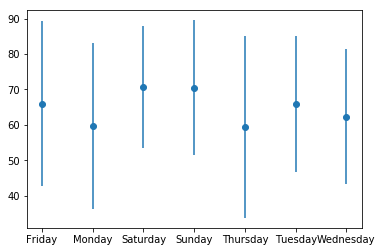

In [161]:
plt.errorbar(x, y, yerr=e, fmt='o')


Why did it put the weekdays out of order again?